In [1]:
import h5py
import ROOT

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
from itertools import repeat

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

MAX_CONSTI = {
    'Jet': 50,
    'Tower': 250,
    'Track': 150,
    'Photon': 2,
}
N_CORES = 64

Welcome to JupyROOT 6.20/08


In [2]:
def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [3]:
def selection_cut(tree, SRBR_cuts={'mjj': 300, 'deta': 3.1}):
    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV

    n_event_count = 0
    n_photon_count = 0
    n_jet_count = 0
    photon_mass_count = 0

    mass, deta = [], []

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Photon_size < 2:
            continue
        n_photon_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue
        photon_mass_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mass.append(mjj)

        detajj = np.abs(jets[0][1] - jets[1][1])
        deta.append(detajj)


    mass = np.array(mass)
    deta = np.array(deta)
    mjj_SR_count = (mass > SRBR_cuts['mjj']).sum()
    mjj_BR_count = (mass < SRBR_cuts['mjj']).sum()
    deta_SR_count = (deta > SRBR_cuts['deta']).sum()
    deta_BR_count = (deta < SRBR_cuts['deta']).sum()
    mjj_deta_SR_count = ((mass > SRBR_cuts['mjj']) & (deta > SRBR_cuts['deta'])).sum()
    mjj_deta_BR_count = ((mass < SRBR_cuts['mjj']) & (deta < SRBR_cuts['deta'])).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n photon cut': n_jet_count,
        'n jet cut': n_jet_count,
        'photon mass cut': photon_mass_count,
        'mjj: sig region': mjj_SR_count,
        'mjj: bkg region': mjj_BR_count,
        'deta: sig region': deta_SR_count,
        'deta: bkg region': deta_BR_count,
        'mjj, deta: sig region': mjj_deta_SR_count,
        'mjj, deta: bkg region': mjj_deta_BR_count,
    }

    results = {
        'mjj': mass,
        'deta': deta,
        'cutflow_number': cutflow_number,
    }

    return results

In [9]:
def selection_cut_gluon_jet(tree):
    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV

    n_event_count = 0
    n_photon_count = 0
    n_jet_count = 0
    photon_mass_count = 0

    mass, deta = [], []
    jet_flavor = [[], []]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Photon_size < 2:
            continue
        n_photon_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue
        photon_mass_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mass.append(mjj)

        detajj = np.abs(jets[0][1] - jets[1][1])
        deta.append(detajj)

        jet_flavor[0].append(event.Jet[0].Flavor)
        jet_flavor[1].append(event.Jet[1].Flavor)



    mass = np.array(mass)
    deta = np.array(deta)
    jet_flavor = np.array(jet_flavor)

    two_gluon_jet_SR_count = ((jet_flavor[0] == 21) & (jet_flavor[1] == 21)).sum()
    two_gluon_jet_BR_count = ((jet_flavor[0] != 21) | (jet_flavor[1] != 21)).sum()
    one_gluon_jet_SR_count = ((jet_flavor[0] == 21) | (jet_flavor[1] == 21)).sum()
    one_gluon_jet_BR_count = ((jet_flavor[0] != 21) & (jet_flavor[1] != 21)).sum()

    one_gluon_jet_count = ((jet_flavor[0] == 21) & (jet_flavor[1] != 21)).sum() + ((jet_flavor[0] != 21) & (jet_flavor[1] == 21)).sum()
    zero_gluon_jet_count = ((jet_flavor[0] != 21) & (jet_flavor[1] != 21)).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n photon cut': n_jet_count,
        'n jet cut': n_jet_count,
        'photon mass cut': photon_mass_count,
        'two gluon jet: sig region': two_gluon_jet_SR_count,
        'two gluon jet: bkg region': two_gluon_jet_BR_count,
        'one gluon jet: sig region': one_gluon_jet_SR_count,
        'one gluon jet: bkg region': one_gluon_jet_BR_count,
        'two gluon jet': two_gluon_jet_SR_count,
        'one gluon jet': one_gluon_jet_count,
        'zero gluon jet': zero_gluon_jet_count,
    }
    

    results = {
        'mjj': mass,
        'deta': deta,
        'cutflow_number': cutflow_number,
    }

    return results

def selection_cut_quark_jet(tree):
    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV

    n_event_count = 0
    n_photon_count = 0
    n_jet_count = 0
    photon_mass_count = 0

    mass, deta = [], []
    jet_flavor = [[], []]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Photon_size < 2:
            continue
        n_photon_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue
        photon_mass_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mass.append(mjj)

        detajj = np.abs(jets[0][1] - jets[1][1])
        deta.append(detajj)

        jet_flavor[0].append(event.Jet[0].Flavor)
        jet_flavor[1].append(event.Jet[1].Flavor)



    mass = np.array(mass)
    deta = np.array(deta)
    jet_flavor = np.array(jet_flavor)

    two_quark_jet_SR_count = ((jet_flavor[0] < 6) & (jet_flavor[1] < 6)).sum()
    two_quark_jet_BR_count = ((jet_flavor[0] >= 6) | (jet_flavor[1] >= 6)).sum()
    one_quark_jet_SR_count = ((jet_flavor[0] < 6) | (jet_flavor[1] < 6)).sum()
    one_quark_jet_BR_count = ((jet_flavor[0] >= 6) & (jet_flavor[1] >= 6)).sum()

    one_quark_jet_count = ((jet_flavor[0] < 6) & (jet_flavor[1] >= 6)).sum() + ((jet_flavor[0] >= 6) & (jet_flavor[1] < 6)).sum()
    zero_quark_jet_count = ((jet_flavor[0] >= 6) & (jet_flavor[1] >= 6)).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n photon cut': n_jet_count,
        'n jet cut': n_jet_count,
        'photon mass cut': photon_mass_count,
        'two quark jet: sig region': two_quark_jet_SR_count,
        'two quark jet: bkg region': two_quark_jet_BR_count,
        'one quark jet: sig region': one_quark_jet_SR_count,
        'one quark jet: bkg region': one_quark_jet_BR_count,
        'two quark jet': two_quark_jet_SR_count,
        'one quark jet': one_quark_jet_count,
        'zero quark jet': zero_quark_jet_count,
    }
    

    results = {
        'mjj': mass,
        'deta': deta,
        'cutflow_number': cutflow_number,
    }

    return results

def selection_cut_2q2g_jet(tree):
    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV

    n_event_count = 0
    n_photon_count = 0
    n_jet_count = 0
    photon_mass_count = 0

    mass, deta = [], []
    jet_flavor = [[], []]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Photon_size < 2:
            continue
        n_photon_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue
        photon_mass_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mass.append(mjj)

        detajj = np.abs(jets[0][1] - jets[1][1])
        deta.append(detajj)

        jet_flavor[0].append(event.Jet[0].Flavor)
        jet_flavor[1].append(event.Jet[1].Flavor)



    mass = np.array(mass)
    deta = np.array(deta)
    jet_flavor = np.array(jet_flavor)

    two_quark_jet_SR_count = ((jet_flavor[0] < 6) & (jet_flavor[1] < 6)).sum()
    two_gloun_jet_BR_count = ((jet_flavor[0] == 21) & (jet_flavor[1] == 21)).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n photon cut': n_jet_count,
        'n jet cut': n_jet_count,
        'photon mass cut': photon_mass_count,
        'two quark jet: sig region': two_quark_jet_SR_count,
        'two gluon jet: bkg region': two_gloun_jet_BR_count,
    }
    

    results = {
        'mjj': mass,
        'deta': deta,
        'cutflow_number': cutflow_number,
    }

    return results

In [16]:
def get_mass_and_deta(tree):
    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV
    counts = [0, 0, 0]
    mass, deta = [], []
    jet_flavor = [[], []]
    for event_id, event in tqdm(enumerate(tree)):
        # if event_id == 10:
        #     break

        if event.Photon_size < 2:
            continue
        counts[0] += 1

        if event.Jet_size < 2:
            continue
        counts[1] += 1

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue
        counts[2] += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mass.append(mjj)

        detajj = np.abs(jets[0][1] - jets[1][1])
        deta.append(detajj)

        jet_flavor[0].append(event.Jet[0].Flavor)
        jet_flavor[1].append(event.Jet[1].Flavor)

    print('Total events:', event_id + 1)
    print('Events with >= 2 photons:', counts[0])
    print('Events with >= 2 jets:', counts[1])
    print('Events with maa in [120, 130] GeV:', counts[2])
    
    return mass, deta, jet_flavor

# Selection efficiency

## $m_{jj} = $ 300 GeV, $\Delta\eta = 3.1$

In [ ]:
root_file = './GGF_Higgs/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_GGF = selection_cut(tree)

In [ ]:
root_file = './VBF_Higgs/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_VBF = selection_cut(tree)

In [ ]:
np.save('./selection_results_GGF_300_3.1.npy', results_GGF)
np.save('./selection_results_VBF_300_3.1.npy', results_VBF)

In [5]:
print('GGF')
GGF_selection = np.load('./selection_results_GGF_300_3.1.npy', allow_pickle=True).item()

n_total = GGF_selection['cutflow_number']['Total']
for key, value in GGF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

print('VBF')
VBF_selection = np.load('./selection_results_VBF_300_3.1.npy', allow_pickle=True).item()

n_total = VBF_selection['cutflow_number']['Total']
for key, value in VBF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

GGF
Total                        100000   &     1.00
n photon cut                 9302     &     0.09
n jet cut                    9302     &     0.09
photon mass cut              8864     &     0.09
mjj: sig region              2695     &     0.03
mjj: bkg region              6169     &     0.06
deta: sig region             2317     &     0.02
deta: bkg region             6547     &     0.07
mjj, deta: sig region        1832     &     0.02
mjj, deta: bkg region        5684     &     0.06
VBF
Total                        100000   &     1.00
n photon cut                 42860    &     0.43
n jet cut                    42860    &     0.43
photon mass cut              40694    &     0.41
mjj: sig region              29496    &     0.29
mjj: bkg region              11198    &     0.11
deta: sig region             28160    &     0.28
deta: bkg region             12534    &     0.13
mjj, deta: sig region        26446    &     0.26
mjj, deta: bkg region        9484     &     0.09


In [6]:
# compute number of events in signal region and background region
L = 3000
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000
BR_Haa = 0.00227

print('mjj cut: 300 GeV')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('deta cut: 3.1')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('mjj, deta cut: 300 GeV, 3.1')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

mjj cut: 300 GeV
     GGF      VBF     
BR   22967    & 3262    
SR   10034    & 8593    
deta cut: 3.1
     GGF      VBF     
BR   24375    & 3652    
SR   8626     & 8204    
mjj, deta cut: 300 GeV, 3.1
     GGF      VBF     
BR   21162    & 2763    
SR   6821     & 7705    


## $m_{jj} = $ 225 GeV, $\Delta\eta = 2.30$

In [5]:
root_file = './GGF_Higgs/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
SRBR_cuts={'mjj': 225, 'deta': 2.30}
results_GGF = selection_cut(tree, SRBR_cuts)

100000it [01:26, 1152.55it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class Track read from file ./GGF_Higgs/Events/run_02/tag_1_delphes_events.root
   has the same version (=3) as the active class but a different checksum.
   You should update the version to ClassDef(Track,4).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float C; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float Mass; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float EtaOuter; //
Warning in <TStreamerInfo::CompareCo

In [6]:
root_file = './VBF_Higgs/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
SRBR_cuts={'mjj': 225, 'deta': 2.30}
results_VBF = selection_cut(tree, SRBR_cuts)

100000it [01:44, 957.42it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./VBF_Higgs/Events/run_02/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./VBF_Higgs/Events/run_02/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInf

In [7]:
np.save('./selection_results_GGF_225_2.3.npy', results_GGF)
np.save('./selection_results_VBF_225_2.3.npy', results_VBF)

In [8]:
print('GGF')
GGF_selection = np.load('./selection_results_GGF_225_2.3.npy', allow_pickle=True).item()

n_total = GGF_selection['cutflow_number']['Total']
for key, value in GGF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

print('VBF')
VBF_selection = np.load('./selection_results_VBF_225_2.3.npy', allow_pickle=True).item()

n_total = VBF_selection['cutflow_number']['Total']
for key, value in VBF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

GGF
Total                        100000   &     1.00
n photon cut                 9302     &     0.09
n jet cut                    9302     &     0.09
photon mass cut              8864     &     0.09
mjj: sig region              3638     &     0.04
mjj: bkg region              5226     &     0.05
deta: sig region             3611     &     0.04
deta: bkg region             5253     &     0.05
mjj, deta: sig region        2842     &     0.03
mjj, deta: bkg region        4457     &     0.04
VBF
Total                        100000   &     1.00
n photon cut                 42860    &     0.43
n jet cut                    42860    &     0.43
photon mass cut              40694    &     0.41
mjj: sig region              32993    &     0.33
mjj: bkg region              7701     &     0.08
deta: sig region             32914    &     0.33
deta: bkg region             7780     &     0.08
mjj, deta: sig region        31113    &     0.31
mjj, deta: bkg region        5900     &     0.06


In [9]:
# compute number of events in signal region and background region
L = 3000
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000
BR_Haa = 0.00227

print('mjj cut: 275 GeV')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('deta cut: 2.65')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('mjj, deta cut: 275 GeV, 2.65')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['mjj, deta: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['mjj, deta: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

mjj cut: 275 GeV
     GGF      VBF     
BR   19457    & 2244    
SR   13544    & 9612    
deta cut: 2.65
     GGF      VBF     
BR   19557    & 2267    
SR   13444    & 9589    
mjj, deta cut: 275 GeV, 2.65
     GGF      VBF     
BR   16594    & 1719    
SR   10581    & 9064    


## Gluon jet number

In [ ]:
root_file = './GGF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_GGF = selection_cut_gluon_jet(tree)

root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_VBF = selection_cut_gluon_jet(tree)

10000it [00:08, 1143.91it/s]
10000it [00:10, 928.77it/s]


In [32]:
np.save('./selection_results_GGF_gluon_jet.npy', results_GGF)
np.save('./selection_results_VBF_gluon_jet.npy', results_VBF)

In [33]:
print('GGF')
GGF_selection = np.load('./selection_results_GGF_gluon_jet.npy', allow_pickle=True).item()

n_total = GGF_selection['cutflow_number']['Total']
for key, value in GGF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

print('VBF')
VBF_selection = np.load('./selection_results_VBF_gluon_jet.npy', allow_pickle=True).item()

n_total = VBF_selection['cutflow_number']['Total']
for key, value in VBF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

GGF
Total                        10000    &     1.00
n photon cut                 949      &     0.09
n jet cut                    949      &     0.09
photon mass cut              905      &     0.09
two gluon jet: sig region    79       &     0.01
two gluon jet: bkg region    826      &     0.08
one gluon jet: sig region    453      &     0.05
one gluon jet: bkg region    452      &     0.05
two gluon jet                79       &     0.01
one gluon jet                374      &     0.04
zero gluon jet               452      &     0.05
VBF
Total                        10000    &     1.00
n photon cut                 4257     &     0.43
n jet cut                    4257     &     0.43
photon mass cut              4059     &     0.41
two gluon jet: sig region    16       &     0.00
two gluon jet: bkg region    4043     &     0.40
one gluon jet: sig region    548      &     0.05
one gluon jet: bkg region    3511     &     0.35
two gluon jet                16       &     0.00
one gluon je

In [29]:
# compute number of events in signal region and background region
L = 3000
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000
BR_Haa = 0.00227

print('= 2 gluon jets')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('>= 1 gluon jet')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['one gluon jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['one gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['one gluon jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['one gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')


= 2 gluon jets
     GGF      VBF     
BR   30752    & 11779   
SR   2941     & 47      
>= 1 gluon jet
     GGF      VBF     
BR   16828    & 10229   
SR   16865    & 1596    


## Quark jet number

In [5]:
root_file = './GGF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_GGF = selection_cut_quark_jet(tree)

root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_VBF = selection_cut_quark_jet(tree)

10000it [00:10, 945.65it/s]
10000it [00:12, 813.05it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class Track read from file ./GGF_Higgs/Events/run_01/tag_1_delphes_events.root
   has the same version (=3) as the active class but a different checksum.
   You should update the version to ClassDef(Track,4).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float C; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float Mass; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 3 of class 'Track' is missing from 
the on-file layout version 3:
   float EtaOuter; //
Warning in

In [6]:
np.save('./selection_results_GGF_quark_jet.npy', results_GGF)
np.save('./selection_results_VBF_quark_jet.npy', results_VBF)

In [7]:
print('GGF')
GGF_selection = np.load('./selection_results_GGF_quark_jet.npy', allow_pickle=True).item()

n_total = GGF_selection['cutflow_number']['Total']
for key, value in GGF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

print('VBF')
VBF_selection = np.load('./selection_results_VBF_quark_jet.npy', allow_pickle=True).item()

n_total = VBF_selection['cutflow_number']['Total']
for key, value in VBF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

GGF
Total                        10000    &     1.00
n photon cut                 949      &     0.09
n jet cut                    949      &     0.09
photon mass cut              905      &     0.09
two quark jet: sig region    452      &     0.05
two quark jet: bkg region    453      &     0.05
one quark jet: sig region    826      &     0.08
one quark jet: bkg region    79       &     0.01
two quark jet                452      &     0.05
one quark jet                374      &     0.04
zero quark jet               79       &     0.01
VBF
Total                        10000    &     1.00
n photon cut                 4257     &     0.43
n jet cut                    4257     &     0.43
photon mass cut              4059     &     0.41
two quark jet: sig region    3511     &     0.35
two quark jet: bkg region    548      &     0.05
one quark jet: sig region    4043     &     0.40
one quark jet: bkg region    16       &     0.00
two quark jet                3511     &     0.35
one quark je

In [8]:
# compute number of events in signal region and background region
L = 3000
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000
BR_Haa = 0.00227

print('= 2 quark jets')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')

print('>= 1 quark jet')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['one quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['one quark jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['one quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['one quark jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')


= 2 quark jets
     GGF      VBF     
BR   16865    & 1596    
SR   16828    & 10229   
>= 1 quark jet
     GGF      VBF     
BR   2941     & 47      
SR   30752    & 11779   


## 2 Quark jet & 2 Gluon jet

In [10]:
root_file = './GGF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_GGF = selection_cut_2q2g_jet(tree)

root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
results_VBF = selection_cut_2q2g_jet(tree)

10000it [00:08, 1152.99it/s]
10000it [00:10, 930.70it/s]


In [11]:
np.save('./selection_results_GGF_2q2g_jet.npy', results_GGF)
np.save('./selection_results_VBF_2q2g_jet.npy', results_VBF)

In [12]:
print('GGF')
GGF_selection = np.load('./selection_results_GGF_2q2g_jet.npy', allow_pickle=True).item()

n_total = GGF_selection['cutflow_number']['Total']
for key, value in GGF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

print('VBF')
VBF_selection = np.load('./selection_results_VBF_2q2g_jet.npy', allow_pickle=True).item()

n_total = VBF_selection['cutflow_number']['Total']
for key, value in VBF_selection['cutflow_number'].items():
    print(f'{key:28} {value:<8} & {value/n_total:8.2f}')

GGF
Total                        10000    &     1.00
n photon cut                 949      &     0.09
n jet cut                    949      &     0.09
photon mass cut              905      &     0.09
two quark jet: sig region    452      &     0.05
two gluon jet: bkg region    79       &     0.01
VBF
Total                        10000    &     1.00
n photon cut                 4257     &     0.43
n jet cut                    4257     &     0.43
photon mass cut              4059     &     0.41
two quark jet: sig region    3511     &     0.35
two gluon jet: bkg region    16       &     0.00


In [14]:
# compute number of events in signal region and background region
L = 3000
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000
BR_Haa = 0.00227

print('SR: 2 quark jets; BR: 2 gluon jets')
n_GGF_SR = cross_section_GGF * GGF_selection['cutflow_number']['two quark jet: sig region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_GGF_BR = cross_section_GGF * GGF_selection['cutflow_number']['two gluon jet: bkg region'] / GGF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_SR = cross_section_VBF * VBF_selection['cutflow_number']['two quark jet: sig region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
n_VBF_BR = cross_section_VBF * VBF_selection['cutflow_number']['two gluon jet: bkg region'] / VBF_selection['cutflow_number']['Total'] * BR_Haa * L
print(f'{"  ":<4} {"GGF":<8} {"VBF":<8}')
print(f'{"BR":<4} {n_GGF_BR:<8.0f} & {n_VBF_BR:<8.0f}')
print(f'{"SR":<4} {n_GGF_SR:<8.0f} & {n_VBF_SR:<8.0f}')


SR: 2 quark jets; BR: 2 gluon jets
     GGF      VBF     
BR   2941     & 47      
SR   16828    & 10229   


# Plot distribution

In [14]:
root_file = './GGF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
mjj_GGF, deta_GGF, jet_flavor_GGF = get_mass_and_deta(tree)

root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
mjj_VBF, deta_VBF, jet_flavor_VBF = get_mass_and_deta(tree)

0it [00:00, ?it/s]

10000it [00:08, 1136.30it/s]


Total events: 10000
Events with >= 2 photons: 4788
Events with >= 2 jets: 949
Events with maa in [120, 130] GeV: 905


10000it [00:11, 855.91it/s]

Total events: 10000
Events with >= 2 photons: 5293
Events with >= 2 jets: 4257
Events with maa in [120, 130] GeV: 4059



Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./VBF_Higgs/Events/run_01/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./VBF_Higgs/Events/run_01/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInfo::CompareContent>: The foll

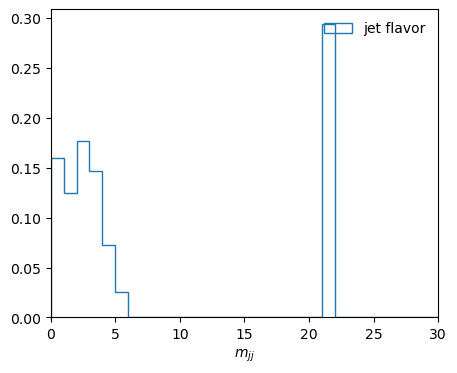

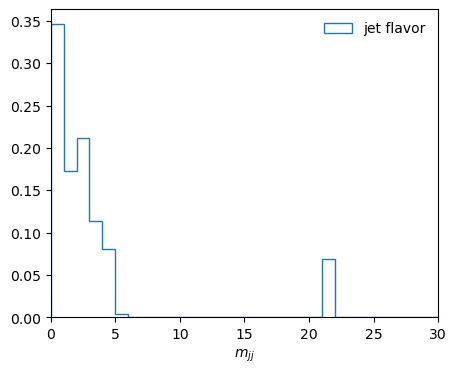

In [ ]:
jet_flavor_GGF = np.array(jet_flavor_GGF)
jet_flavor_GGF = jet_flavor_GGF.flatten()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# ax.hist(jet_flavor_GGF[0], bins=30, range=[0, 30], histtype='step', label='leading jet', density=True)
# ax.hist(jet_flavor_GGF[1], bins=30, range=[0, 30], histtype='step', label='sub-leading jet', density=True)
ax.hist(jet_flavor_GGF, bins=30, range=[0, 30], histtype='step', label='jet flavor', density=True)

ax.set_xlabel('$m_{jj}$')
ax.set_xlim(0, 30)
ax.legend(frameon=False)
# plt.savefig('../figures/mjj_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')

plt.show()

# plot jet flavor distribtuion
jet_flavor_VBF = np.array(jet_flavor_VBF)
jet_flavor_VBF = jet_flavor_VBF.flatten()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# ax.hist(jet_flavor_VBF[0], bins=30, range=[0, 30], histtype='step', label='leading jet', density=True)
# ax.hist(jet_flavor_VBF[1], bins=30, range=[0, 30], histtype='step', label='sub-leading jet', density=True)
ax.hist(jet_flavor_VBF, bins=30, range=[0, 30], histtype='step', label='jet flavor', density=True)
ax.set_xlabel('$m_{jj}$')
ax.set_xlim(0, 30)
ax.legend(frameon=False)
# plt.savefig('../figures/mjj_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')

plt.show()

In [17]:
root_file = './GGF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')
mjj_GGF, deta_GGF = get_mass_and_deta(tree)

root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get("Delphes")
mjj_VBF, deta_VBF = get_mass_and_deta(tree)

10000it [00:10, 973.48it/s]


Total events: 10000
Events with >= 2 photons: 4788
Events with >= 2 jets: 949
Events with maa in [120, 130] GeV: 905


10000it [00:12, 819.54it/s]

Total events: 10000
Events with >= 2 photons: 5293
Events with >= 2 jets: 4257
Events with maa in [120, 130] GeV: 4059


In [25]:
# find the cut such the number of GGF events in signal region and background region are equal
mjj_GGF = np.array(mjj_GGF)
mjj_VBF = np.array(mjj_VBF)
for cut in range(200, 310, 5):
    n_GGF_SR = (mjj_GGF > cut).sum() / len(mjj_GGF)
    n_GGF_BR = (mjj_GGF < cut).sum() / len(mjj_GGF)
    n_VBF_SR = (mjj_VBF > cut).sum() / len(mjj_VBF)
    n_VBF_BR = (mjj_VBF < cut).sum() / len(mjj_VBF)
    print(cut, (n_GGF_SR *32 + n_VBF_SR * 12) / (n_GGF_BR * 32 + n_VBF_BR * 12))

for cut in np.linspace(2.0, 3.0, 11):

    n_GGF_SR = (deta_GGF > cut).sum() / len(deta_GGF)
    n_GGF_BR = (deta_GGF < cut).sum() / len(deta_GGF)
    n_VBF_SR = (deta_VBF > cut).sum() / len(deta_VBF)
    n_VBF_BR = (deta_VBF < cut).sum() / len(deta_VBF)
    print(cut, (n_GGF_SR *32 + n_VBF_SR * 12) / (n_GGF_BR * 32 + n_VBF_BR * 12))

200 1.2053354614226772
205 1.1556581903348788
210 1.1105375392461203
215 1.0860434061828999
220 1.0379068005650833
225 1.0061294483853915
230 0.9750657592009357
235 0.9533427850204295
240 0.9273584253634712
245 0.9073997812931123
250 0.8926326226150312
255 0.8586808791268843
260 0.847623590065634
265 0.8310658074184926
270 0.8117181071937736
275 0.792343197590677
280 0.7776060764072419
285 0.7599901684958308
290 0.7417002594230622
295 0.7241859790531562
300 0.7019605548831787
305 0.6859961869197906
2.0 1.2800847495643937
2.1 1.1865563565519102
2.2 1.1006833050052576
2.3 1.0320415318043692
2.4 0.9597217972484398
2.5 0.8766808683291594
2.6 0.824582685645199
2.7 0.7700457048733862
2.8 0.6965975630370864
2.9 0.6480584119087938
3.0 0.5977609236732554


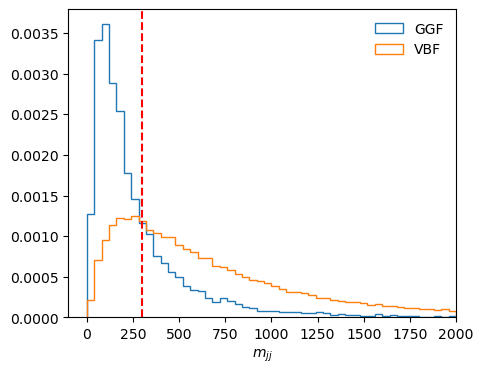

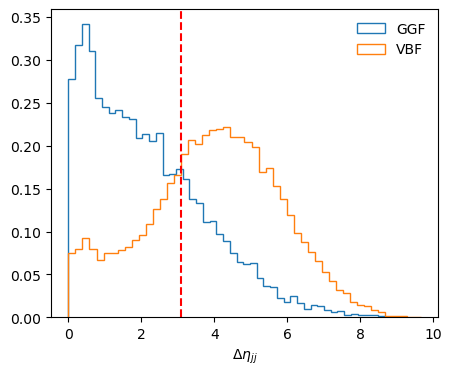

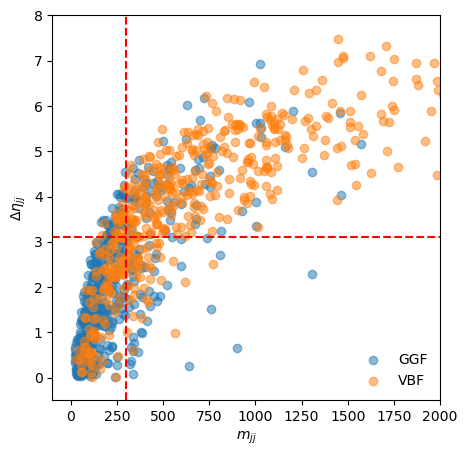

In [ ]:
cuts = {'mjj': 300, 'deta': 3.1}

# plot mjj and detajj distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(mjj_GGF, bins=50, range=[0, 2000], histtype='step', label='GGF', density=True)
ax.hist(mjj_VBF, bins=50, range=[0, 2000], histtype='step', label='VBF', density=True)
ax.axvline(cuts['mjj'], color='r', linestyle='--')
ax.set_xlabel('$m_{jj}$')
ax.set_xlim(-100, 2000)
ax.legend(frameon=False)
plt.savefig('../figures/mjj_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(deta_GGF, bins=50, histtype='step', label='GGF', density=True)
ax.hist(deta_VBF, bins=50, histtype='step', label='VBF', density=True)
ax.axvline(cuts['deta'], color='r', linestyle='--')
ax.set_xlabel('$\Delta\eta_{jj}$')
ax.legend(frameon=False)
plt.savefig('../figures/deta_distribution.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# plot mjj and detajj scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(mjj_GGF[:500], deta_GGF[:500], marker='o', alpha=0.5, label='GGF')
ax.scatter(mjj_VBF[:500], deta_VBF[:500], marker='o', alpha=0.5, label='VBF')
ax.axvline(cuts['mjj'], color='r', linestyle='--')
ax.axhline(cuts['deta'], color='r', linestyle='--')
ax.set_xlabel('$m_{jj}$')
ax.set_ylabel('$\Delta\eta_{jj}$')
ax.set_xlim(-100, 2000)
ax.set_ylim(-0.5, 8)
ax.legend(frameon=False)
plt.savefig('../figures/mjj_deta_scatter_plot.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Basic Information

In [6]:
def get_number_of_constituents(tree):

    # get invariant mass and delta eta of two leading jets
    # 1. number of photons >= 2
    # 2. number of jets >= 2
    # 3. invariant mass of two leading photons in [120, 130] GeV

    n_consti = [[], [], [], [], []]

    for event_id, event in tqdm(enumerate(tree)):
        # if event_id == 10:
        #     break

        if event.Photon_size < 2:
            continue

        if event.Jet_size < 2:
            continue

        # compute invariant mass of two leading photons
        photons = [[event.Photon[i].PT, event.Photon[i].Eta, event.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue

        # Get number of constituents
        constituents = [consti for consti in event.Jet[0].Constituents if consti != 0]
        n_consti[0].append(len(constituents))

        constituents = [consti for consti in event.Jet[1].Constituents if consti != 0]
        n_consti[1].append(len(constituents))

        # extract all track and tower constituents
        constituents = [consti for consti in event.Tower if consti != 0]
        n_consti[2].append(len(constituents))

        constituents = [consti for consti in event.Track if consti != 0]
        n_consti[3].append(len(constituents))
    return n_consti

In [7]:
root_file = './GGF_Higgs/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

n_consti = get_number_of_constituents(tree)

100000it [01:29, 1120.81it/s]


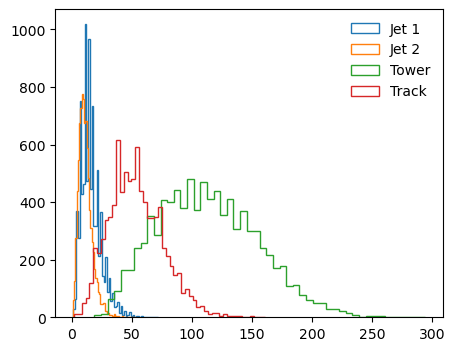

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_consti[0], bins=50, histtype='step', label='Jet 1')
ax.hist(n_consti[1], bins=50, histtype='step', label='Jet 2')
ax.hist(n_consti[2], bins=50, histtype='step', label='Tower')
ax.hist(n_consti[3], bins=50, histtype='step', label='Track')
ax.legend(frameon=False)
plt.show()

In [9]:
root_file = './VBF_Higgs/Events/run_01/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree = f.Get('Delphes')

n_consti_s = get_number_of_constituents(tree)

10000it [00:11, 888.55it/s]


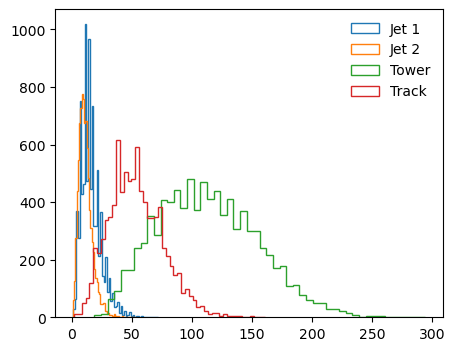

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(n_consti[0], bins=50, histtype='step', label='Jet 1')
ax.hist(n_consti[1], bins=50, histtype='step', label='Jet 2')
ax.hist(n_consti[2], bins=50, histtype='step', label='Tower')
ax.hist(n_consti[3], bins=50, histtype='step', label='Track')
ax.legend(frameon=False)
plt.show()

# From .root to .h5

In [18]:
# HDF5
def create_dataset(f, nevent, MAX_CONSTI):

    f.create_dataset('J1/mask', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='|b1')
    f.create_dataset('J1/pt', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J1/eta', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J1/phi', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J1/flavor', (nevent,), maxshape=(None,), dtype='<i8')

    f.create_dataset('J2/mask', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='|b1')
    f.create_dataset('J2/pt', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J2/eta', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J2/phi', (nevent, MAX_CONSTI['Jet']), maxshape=(None, MAX_CONSTI['Jet']), dtype='<f4')
    f.create_dataset('J2/flavor', (nevent,), maxshape=(None,), dtype='<i8')

    f.create_dataset('TOWER/mask', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='|b1')
    f.create_dataset('TOWER/pt', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')
    f.create_dataset('TOWER/eta', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')
    f.create_dataset('TOWER/phi', (nevent, MAX_CONSTI['Tower']), maxshape=(None, MAX_CONSTI['Tower']), dtype='<f4')

    f.create_dataset('TRACK/mask', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='|b1')
    f.create_dataset('TRACK/pt', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')
    f.create_dataset('TRACK/eta', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')
    f.create_dataset('TRACK/phi', (nevent, MAX_CONSTI['Track']), maxshape=(None, MAX_CONSTI['Track']), dtype='<f4')

    f.create_dataset('PHOTON/pt', (nevent, MAX_CONSTI['Photon']), maxshape=(None, MAX_CONSTI['Photon']), dtype='<f4')
    f.create_dataset('PHOTON/eta', (nevent, MAX_CONSTI['Photon']), maxshape=(None, MAX_CONSTI['Photon']), dtype='<f4')
    f.create_dataset('PHOTON/phi', (nevent, MAX_CONSTI['Photon']), maxshape=(None, MAX_CONSTI['Photon']), dtype='<f4')

    f.create_dataset('EVENT/mjj', (nevent,), maxshape=(None,), dtype='<f4')
    f.create_dataset('EVENT/deta', (nevent,), maxshape=(None,), dtype='<f4')
    f.create_dataset('EVENT/type', (nevent,), maxshape=(None,), dtype='<i8')


def write_dataset(file, data: list):
    nevent = len(data)
    
    for key in data[0].keys():
        # Resize
        shape = list(file[key].shape)
        shape[0] = nevent
        file[key].resize(shape)
        # Write
        value = np.array([data_dict[key] for data_dict in data])
        file[key][:] = value


def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

In [19]:
def get_pt_eta_phi(constituents):
    pts = np.array([consti.PT if hasattr(consti, 'PT') else consti.ET for consti in constituents])
    etas = np.array([consti.Eta for consti in constituents])
    phis = np.array([consti.Phi for consti in constituents])
    return pts, etas, phis


def select_event(root_path, sample_type, start, end):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    f = ROOT.TFile(root_path)
    tree = f.Get("Delphes")

    data_list = []
    for i in tqdm(range(start, end)):
        tree.GetEntry(i)

        if tree.Photon_size < 2:
            continue

        if tree.Jet_size < 2:
            continue

        # compute invariant mass of two leading photons
        photons = [[tree.Photon[i].PT, tree.Photon[i].Eta, tree.Photon[i].Phi, 0] for i in range(2)]
        maa = Mjets(*photons)
        if maa < 120 or maa > 130:
            continue

        jets = [[tree.Jet[i].PT, tree.Jet[i].Eta, tree.Jet[i].Phi, tree.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        deta = np.abs(jets[0][1] - jets[1][1])

        # get jet constituents
        constituents = [consti for consti in tree.Jet[0].Constituents if consti != 0]
        n_consti_1 = len(constituents)
        PT1, Eta1, Phi1 = get_pt_eta_phi(constituents)

        constituents = [consti for consti in tree.Jet[1].Constituents if consti != 0]
        n_consti_2 = len(constituents)
        PT2, Eta2, Phi2 = get_pt_eta_phi(constituents)

        # get tower constituents
        constituents = [consti for consti in tree.Tower if consti != 0]
        n_consti_3 = len(constituents)
        PT3, Eta3, Phi3 = get_pt_eta_phi(constituents)

        # get track constituents
        constituents = [consti for consti in tree.Track if consti != 0]
        n_consti_4 = len(constituents)
        PT4, Eta4, Phi4 = get_pt_eta_phi(constituents)

        if n_consti_1 < 5 or n_consti_2 < 5:
            continue

        # 準備寫入資料
        data_dict = {
            'J1/mask': np.arange(MAX_CONSTI['Jet']) < n_consti_1,
            'J1/pt': PT1[:MAX_CONSTI['Jet']] if n_consti_1 > MAX_CONSTI['Jet'] else np.pad(PT1, (0, MAX_CONSTI['Jet']-n_consti_1)),
            'J1/eta': Eta1[:MAX_CONSTI['Jet']] if n_consti_1 > MAX_CONSTI['Jet'] else np.pad(Eta1, (0, MAX_CONSTI['Jet']-n_consti_1)),
            'J1/phi': Phi1[:MAX_CONSTI['Jet']] if n_consti_1 > MAX_CONSTI['Jet'] else np.pad(Phi1, (0, MAX_CONSTI['Jet']-n_consti_1)),
            'J1/flavor': tree.Jet[0].Flavor,

            'J2/mask': np.arange(MAX_CONSTI['Jet']) < n_consti_2,
            'J2/pt': PT2[:MAX_CONSTI['Jet']] if n_consti_2 > MAX_CONSTI['Jet'] else np.pad(PT2, (0, MAX_CONSTI['Jet']-n_consti_2)),
            'J2/eta': Eta2[:MAX_CONSTI['Jet']] if n_consti_2 > MAX_CONSTI['Jet'] else np.pad(Eta2, (0, MAX_CONSTI['Jet']-n_consti_2)),
            'J2/phi': Phi2[:MAX_CONSTI['Jet']] if n_consti_2 > MAX_CONSTI['Jet'] else np.pad(Phi2, (0, MAX_CONSTI['Jet']-n_consti_2)),
            'J2/flavor': tree.Jet[1].Flavor,

            'TOWER/mask': np.arange(MAX_CONSTI['Tower']) < n_consti_3,
            'TOWER/pt': PT3[:MAX_CONSTI['Tower']] if n_consti_3 > MAX_CONSTI['Tower'] else np.pad(PT3, (0, MAX_CONSTI['Tower']-n_consti_3)),
            'TOWER/eta': Eta3[:MAX_CONSTI['Tower']] if n_consti_3 > MAX_CONSTI['Tower'] else np.pad(Eta3, (0, MAX_CONSTI['Tower']-n_consti_3)),
            'TOWER/phi': Phi3[:MAX_CONSTI['Tower']] if n_consti_3 > MAX_CONSTI['Tower'] else np.pad(Phi3, (0, MAX_CONSTI['Tower']-n_consti_3)),

            'TRACK/mask': np.arange(MAX_CONSTI['Track']) < n_consti_4,
            'TRACK/pt': PT4[:MAX_CONSTI['Track']] if n_consti_4 > MAX_CONSTI['Track'] else np.pad(PT4, (0, MAX_CONSTI['Track']-n_consti_4)),
            'TRACK/eta': Eta4[:MAX_CONSTI['Track']] if n_consti_4 > MAX_CONSTI['Track'] else np.pad(Eta4, (0, MAX_CONSTI['Track']-n_consti_4)),
            'TRACK/phi': Phi4[:MAX_CONSTI['Track']] if n_consti_4 > MAX_CONSTI['Track'] else np.pad(Phi4, (0, MAX_CONSTI['Track']-n_consti_4)),

            'PHOTON/pt': np.array([tree.Photon[i].PT for i in range(2)]),
            'PHOTON/eta': np.array([tree.Photon[i].Eta for i in range(2)]),
            'PHOTON/phi': np.array([tree.Photon[i].Phi for i in range(2)]),

            'EVENT/mjj': mjj,
            'EVENT/deta': deta,
            'EVENT/type': sample_type,
        }
        data_list.append(data_dict)

    return data_list


def from_root_to_h5(root_path, output_path, sample_type):
    # Select events and save the jets information to h5 file

    # Get number of events
    f = ROOT.TFile(root_path)
    nevent = f.Get("Delphes").GetEntries()
    print(f'Number of events: {nevent}')

    # Multi-core processing
    print(f'Number of cores: {N_CORES}')
    start = [nevent // N_CORES * i for i in range(N_CORES)]
    end = [nevent // N_CORES * (i+1) for i in range(N_CORES)]
    end[-1] = nevent

    with mp.Pool(processes=N_CORES) as pool:
        results = pool.starmap(select_event, zip(repeat(root_path), repeat(sample_type), start, end))
    data_list = [data_dict for result_list in results for data_dict in result_list]

    # write to h5 file
    with h5py.File(output_path, 'w') as f_out:
        create_dataset(f_out, nevent, MAX_CONSTI)
        write_dataset(f_out, data_list)

In [20]:
sample_types = {
    'GGF': 0,
    'VBF': 1,
}

root_file = './GGF_Higgs/Events/run_03/tag_1_delphes_events.root'
output_path = './data/GGF-03.h5'
sample_type = sample_types['GGF']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


100%|██████████| 15625/15625 [02:45<00:00, 94.44it/s]  


In [21]:
sample_types = {
    'GGF': 0,
    'VBF': 1,
}

root_file = './GGF_Higgs/Events/run_04/tag_1_delphes_events.root'
output_path = './data/GGF-04.h5'
sample_type = sample_types['GGF']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


100%|██████████| 15625/15625 [02:40<00:00, 97.37it/s]  


In [22]:
sample_types = {
    'GGF': 0,
    'VBF': 1,
}

root_file = './VBF_Higgs/Events/run_03/tag_1_delphes_events.root'
output_path = './data/VBF-03.h5'
sample_type = sample_types['VBF']

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 1000000
Number of cores: 64


100%|██████████| 15625/15625 [02:49<00:00, 92.33it/s] 
